# Data streaming

## Task 4. Botnet profiling task

Group 97

Choose a probabilistic sequential model (Markov chain, n-grams, state machines, HMMs, ...) Use a sliding window to obtain sequence data. Learn a probabilistic sequential model from the data of one infected host and match its profile with all other hosts from the same scenario. Evaluate how many new infections your method finds and false positives it raises. Can you determine what behaviour your profile detects?

Per documentation, the distribution of labels in the NetFlows for scenario 10 in the dataset is:

Total flows | Botnet flows    | Normal flows  | C&C flows  | Background flows
------------|-----------------|---------------|------------|-------------------
1,309,791   | 106,315 (8.11%) | 15,847 (1.2%) | 37 (.002%) | 1,187,592 (90.67%)

Reference: "An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from string import ascii_lowercase

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # disable specific warning

np.random.seed(42)
random.seed(42)
%matplotlib inline

In [2]:
# define filepath for scenario 10 dataset
filepath = './data/capture20110818.pcap.netflow.labeled'

# read data from the file
f = open(filepath, 'r')
lines = f.readlines()
f.close()
data = lines[1:] # drop the header

In [3]:
def preprocessing_remove_Background(data):
    '''data preprocessing
    Input
    -----
    data: string of a data flow
    
    Return
    ------
    o = None, if Background flow (to be removed)
    o = cleaned, formated data, if not Background flow
    '''
    if not 'Background' in data:
        s = data.split('\t')
        s = [x for x in s if x] # remove empty elements
        if len(s) < 12: # special fix for an outlier string @2011-08-18 12:18:31.264
            s = s[0].rsplit(' ', 11) 
        o = np.array([pd.to_datetime(s[0], format='%Y-%m-%d %H:%M:%S.%f'), # timestamp
                      float(s[1]), # duration
                      s[2], # protocol
                      s[3].split(':')[0], # ScrAddr
                      s[5].split(':')[0], # DstAddr
                      s[6].lstrip('_').rstrip('_').rstrip(), # flags
                      int(s[7]), # Tos
                      int(s[8]), # packets
                      int(s[9]), # bytes
                      int(s[10]), # flows
                      s[11].rstrip('\n').rstrip() # label
                     ])
    else: # if Background flow
        o = None
    return o

In [4]:
df = list(map(preprocessing_remove_Background, data)) # data preprocessing
df = [x for x in df if isinstance(x, np.ndarray)] # remove background flows
df = pd.DataFrame(df, columns=['Time', 'Duration', 'Protocol', 'ScrAddr', 'DstAddr', 
                               'Flags', 'Tos', 'Packets', 'Bytes', 'Flows', 'Label'])
df.set_index('Time', drop=True, inplace=True)

In [5]:
df.head()

,Duration,Protocol,ScrAddr,DstAddr,Flags,Tos,Packets,Bytes,Flows,Label
Time,,,,,,,,,,
2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,147.32.85.88,PA,0,91,86277,1,LEGITIMATE
2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,74.125.232.214,A,0,1,66,1,LEGITIMATE
2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,147.32.80.13,A,0,49,3234,1,LEGITIMATE
2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,74.125.108.208,A,0,118,7080,1,LEGITIMATE
2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,74.125.232.215,A,0,1,60,1,LEGITIMATE


In this assignment, **normal host 147.32.87.11 is removed** from the analysis because it contains only 4 data flows.

In [6]:
# list of infected hosts and normal hosts
infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', 
                  '147.32.84.193', '147.32.84.204', '147.32.84.205', 
                  '147.32.84.206', '147.32.84.207', '147.32.84.208', '147.32.84.209']
normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164',
                '147.32.87.36', '147.32.80.9'] # 147.32.87.11 is removed as it contains very limited data flows

In [7]:
from random import shuffle

# assign one infected host for training
INFECTED_HOST = infected_hosts[0]

print('For model training, the chosen infected host is {}.\n'.format(INFECTED_HOST))

# the rest are for testing
test_hosts = infected_hosts[1:] + normal_hosts
shuffle(test_hosts)
print('For model testing, IP addresses include: \n{}'.format(test_hosts))

For model training, the chosen infected host is 147.32.84.165.

For model testing, IP addresses include: 
['147.32.84.209', '147.32.87.36', '147.32.84.208', '147.32.84.207', '147.32.80.9', '147.32.84.164', '147.32.84.206', '147.32.84.193', '147.32.84.170', '147.32.84.204', '147.32.84.205', '147.32.84.191', '147.32.84.192', '147.32.84.134']


## 1. Train model

In [8]:
def get_ngrams_profile(host_ip, n_grams=5):
    '''
    Parameters 
    ----------
    host_ip : ip address of the speficied host
    n_grams : number of grams
    
    Return
    ------
    ngrams_profile : profile of the specified host
    
    '''
    # subset data flows associated with the speficied host
    df_host = df.loc[(df.ScrAddr == host_ip)|(df.DstAddr == host_ip), 
                     ['Protocol', 'Packets']] # subset selected features
    df_host.Protocol = LabelEncoder().fit_transform(df_host['Protocol']) # label encoding
    
    # discretise the data flows by clustering
    km = KMeans(n_clusters=5, n_jobs=-1, random_state=42)
    scale_df = scale(df_host.values)
    discretisation = km.fit_predict(scale_df) # using scaled data

    # translate numeric discretisation to strings
    num_to_string = {} # create a dict with key = numeric element, value = translated string
    for i, element in enumerate(np.unique(discretisation)):
        num_to_string[element] = ascii_lowercase[i]
    translation = [num_to_string[element] for element in discretisation]

    # create ngrams
    dict_ngrams = {}
    for i in range(0, len(translation)-n_grams-1): # loop through the trasnlated string
        token = ''.join(translation[i:(i+n_grams)]) # get token through merging n-gram elements (i to(i+n_grams))
        next_element = translation[i+n_grams+1] # get the next element (i+n_grams+1)

        if token not in dict_ngrams.keys(): # if new n-grams, add key into dict
            dict_ngrams[token] = [''.join(next_element)]
        else: # if existing n-grams in key, append the next element
            dict_ngrams[token].append(next_element)

    # calculate likelihoods
    ngrams_profile = {} # create a dict with key = ngrams token, 
                        # values = dict of next elements and their likelihoods
    for key in dict_ngrams.keys():
        # perform unique counts to the next elements
        next_elements, counts = np.unique(dict_ngrams[key], return_counts=True)

        likelihood = {}
        for i, next_element in enumerate(next_elements): # per next element
            likelihood[next_element] = counts[i] / counts.sum() # calculate its likelihood

        ngrams_profile[key] = likelihood # append the likelihoods for the token
        
    return ngrams_profile

In [9]:
# get profile for the specified infect host
NGRAMS = 5
profile_infected = get_ngrams_profile(INFECTED_HOST, NGRAMS)

# print the results
print('\'{}\': {} ... (showing only the first key, cropped the following)'.format(list(profile_infected.keys())[0],
                                                                                  profile_infected[list(profile_infected.keys())[0]]))

'eeeec': {'c': 0.6, 'e': 0.4} ... (showing only the first key, cropped the following)


## 2. Test model

Get the profile for each testing host. Calcualte the similiary / distance of the profile with regard to that of the infected host.

In [10]:
def compare_profile(profile_infected, profile_test):
    '''compare the similarity of testing profile and reference (training, infected) profile
    Parameter
    ---------
    profile_infected: dict of reference profile
    profile_test: dict of testing profile
    
    Return
    ------
    overall_similarity: score of similiarity
    
    '''
    overall_similarity = []
    
    # per ngram token, calculate the consine similarity across elements
    for token in profile_infected.keys():
        if not token in profile_test.keys(): # if token does not exist in reference profile
            token_simliarity = 0
        else: # token exists in both testing and training (infected) profile
            elements = {**profile_infected[token], **profile_test[token]}.keys()
            x = [profile_infected[token][key] if key in profile_infected[token].keys() else 0 
                 for key in elements]
            y = [profile_test[token][key] if key in profile_test[token].keys() else 0 
                 for key in elements]
            # calculate cosine similarity between both profiles
            token_simliarity = np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        overall_similarity.append(token_simliarity)
    
    #return overall_similarity
    overall_similarity = sum(overall_similarity) / len(overall_similarity)        
    return overall_similarity

In [11]:
# assign threshold for similarity
THRESHOLD = 0.14

# compare each host profile with the reference (infected) profile
comparison = {}

for host in test_hosts:
    # compare the host's profile with infected profile
    profile_test = get_ngrams_profile(host, NGRAMS)
    similarity = compare_profile(profile_infected, profile_test)
    
    # assign predicted label
    predicted_label = 0 if similarity < THRESHOLD else 1
    
    # assign real label
    true_label = 1 if host in infected_hosts else 0
    
    # update dict
    comparison.update({host: [similarity, predicted_label, true_label]})

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


In [12]:
# create a dataframe for the results
df_comparison = pd.DataFrame.from_dict(comparison, orient='index')
df_comparison.reset_index(drop=False, inplace=True)
df_comparison.columns = ['Host IP address', 'Similarity', 'Predicted Label', 'True Label']
df_comparison.sort_values('Similarity', ascending=False, inplace=True)
df_comparison

,Host IP address,Similarity,Predicted Label,True Label
7,147.32.84.193,0.774272,1,1
11,147.32.84.191,0.729274,1,1
3,147.32.84.207,0.715989,1,1
12,147.32.84.192,0.699946,1,1
2,147.32.84.208,0.644928,1,1
0,147.32.84.209,0.638402,1,1
6,147.32.84.206,0.421761,1,1
9,147.32.84.204,0.407949,1,1
10,147.32.84.205,0.147493,1,1
13,147.32.84.134,0.134193,0,0


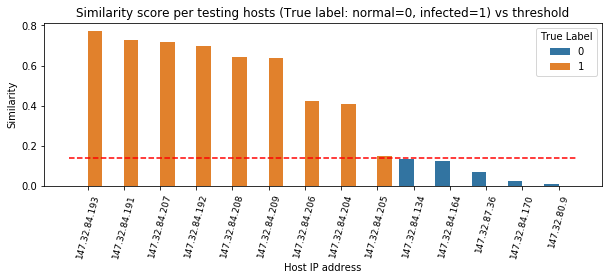

In [26]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data=df_comparison, x='Host IP address', y='Similarity', hue='True Label', ax=ax)
ax.hlines(THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', linestyles='--')
ax.set_title('Similarity score per testing hosts (True label: normal=0, infected=1) vs threshold')
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize': 9}, rotation=75)
plt.show()

[Text(0, 0.5, 'normal'), Text(0, 1.5, 'anomaly')]

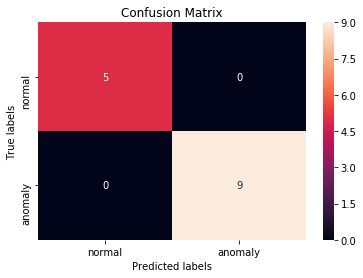

In [20]:
# create confusion matrix plot
df_cm = confusion_matrix(df_comparison['True Label'].values,
                         df_comparison['Predicted Label'].values)

ax = sns.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['normal', 'anomaly'])
ax.yaxis.set_ticklabels(['normal', 'anomaly'])